# Unsupervised Machine Learning for the Classification of Astrophysical X-ray Sources
###### *Víctor Samuel Pérez Díaz<sup>1,2</sup>, Rafael Martinez-Galarza<sup>1</sup>, Alexander Caicedo-Dorado<sup>2</sup>, Raffaele D'Abrusco<sup>1</sup>*

*1. Center for Astrophysics | Harvard & Smithsonian, 2. Universidad del Rosario*

Contact ```vperezdiaz@cfa.harvard.edu``` for questions or comments.


#### Classification validation

---

In [1]:
%load_ext autoreload
%autoreload 2

from umlcaxs_lib import votable_to_pandas, lognorm, mahalanobis, mahal_classifier_cl, create_summary_tables, process_data_for_validation, mahal_classifier_validation
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from statsmodels.stats import inter_rater as irr

from collections import Counter
%matplotlib inline

In [2]:
# Edit the font, font size, and axes width

mpl.rcParams['font.family'] = 'Avenir LT Std'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 2

In [3]:
df_cluster_csc_simbad = pd.read_csv('./out_data/cluster_csc_simbad.csv', index_col=0)

C:\Users\samue\miniconda3\envs\astrox\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (56,63,64,65,66,67,68,73,74) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
nans_df_csc_simbad = df_cluster_csc_simbad.copy(deep=True).fillna({'main_type': 'NaN'})

In [5]:
# Features that we use in our analysis
features = ['hard_hm', 'hard_hs', 'hard_ms', 'powlaw_gamma', 'bb_kt', 'var_prob_b','var_ratio_b', 'var_prob_h', 'var_ratio_h', 'var_prob_s', 'var_ratio_s', 'var_newq_b']

# Features to log transform and normalize
features_lognorm = ['bb_kt', 'var_ratio_h', 'var_ratio_b', 'var_ratio_s', 'var_newq_b']

# Features to normalize
features_norm = ['powlaw_gamma']

# Drop data with missing values in features
df_cscs_out = nans_df_csc_simbad.dropna(subset=features)

In [6]:
# Normalize or log normalize
df_cscs_lognorm = lognorm(df_cscs_out, features, features_norm, features_lognorm)

In [7]:
uks = ['Star', 'X', 'Radio', 'IR', 'Blue', 'UV', 'gamma', 'PartofG', '**']
ltypes = ['QSO', 'AGN', 'Seyfert_1', 'Seyfert_2', 'HMXB', 'LMXB', 'XB', 'YSO', 'TTau*', 'Orion_V*']
grouped_replace = {'QSO': 'AGN', 'Seyfert_1': 'Seyfert', 'Seyfert_2': 'Seyfert', 'HMXB': 'XB', 'LMXB':'XB', 'TTau*':'YSO', 'Orion_V*': 'YSO' }
data_clean = process_data_for_validation(df_cscs_lognorm, ltypes, uks=uks)

#### Experiment with classical classifier

---

[('AGN', 501), ('HMXB', 501), ('LMXB', 501), ('Orion_V*', 502), ('QSO', 501), ('Seyfert_1', 501), ('Seyfert_2', 502), ('TTau*', 501), ('XB', 501), ('YSO', 501)]


'AvenirLTStd-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


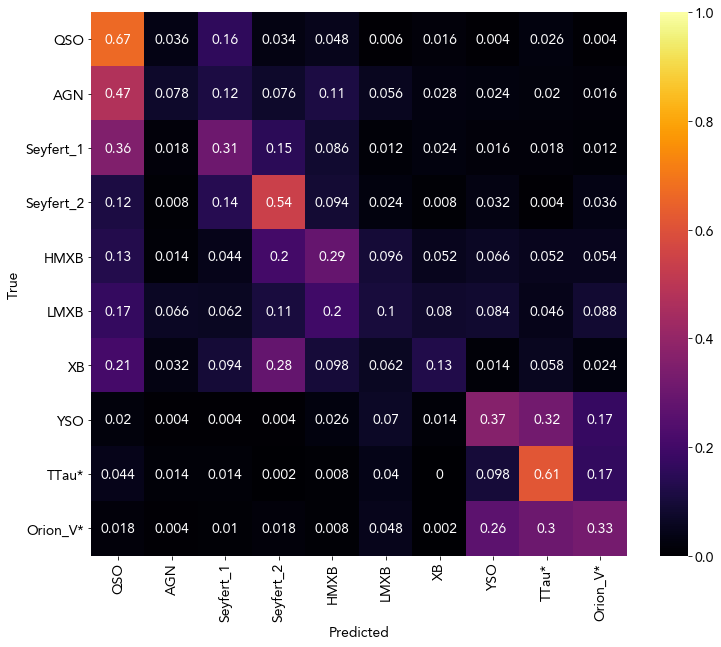

In [9]:
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(data_clean, data_clean.main_type)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

print(sorted(Counter(y_test).items()))

clf = LinearSVC(max_iter=3000)
clf.fit(X_train[features], y_train)

cf_matrix = confusion_matrix(y_test, clf.predict(X_test[features]), normalize='true', labels=ltypes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cf_matrix, annot=True, xticklabels = ltypes, yticklabels = ltypes, ax=ax, vmin=0, vmax=1, cmap="inferno")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.savefig('./figures/results_class_a_linearsvc_raw.pdf', bbox_inches='tight')

'AvenirLTStd-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


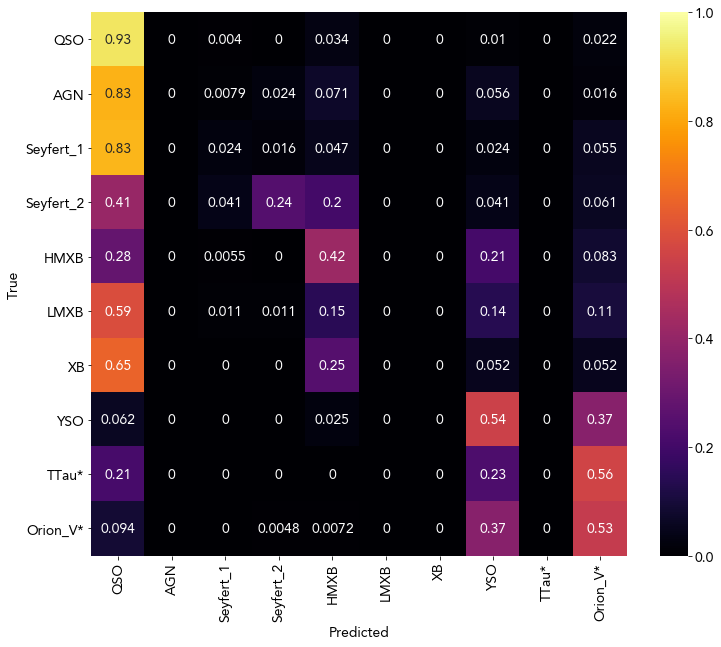

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data_clean, data_clean.main_type, test_size=0.2, stratify=data_clean.main_type, random_state=42)

clf = LinearSVC(max_iter=3000)
clf.fit(X_train[features], y_train)

cf_matrix = confusion_matrix(y_test, clf.predict(X_test[features]), normalize='true', labels=ltypes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cf_matrix, annot=True, xticklabels = ltypes, yticklabels = ltypes, ax=ax, vmin=0, vmax=1, cmap="inferno")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
#plt.savefig('./figures/results_class_a_linearsvc_raw_unbalanced.pdf', bbox_inches='tight')

Text(83.0, 0.5, 'True')

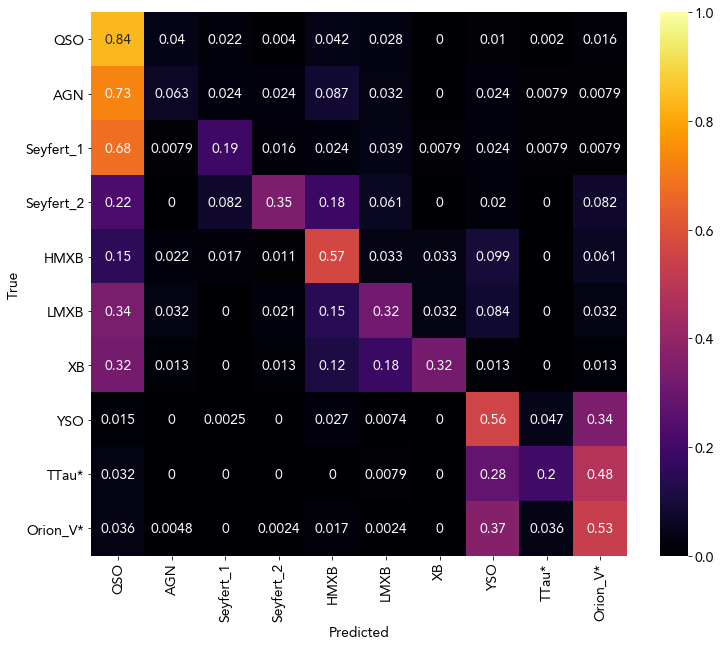

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data_clean, data_clean.main_type, test_size=0.2, stratify=data_clean.main_type, random_state=42)

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=1000, random_state=0)
clf.fit(X_train[features], y_train)

cf_matrix = confusion_matrix(y_test, clf.predict(X_test[features]), normalize='true', labels=ltypes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cf_matrix, annot=True, xticklabels = ltypes, yticklabels = ltypes, ax=ax, vmin=0, vmax=1, cmap="inferno")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
#plt.savefig('./figures/results_class_a_linearsvc_raw_unbalanced.pdf', bbox_inches='tight')

'AvenirLTStd-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


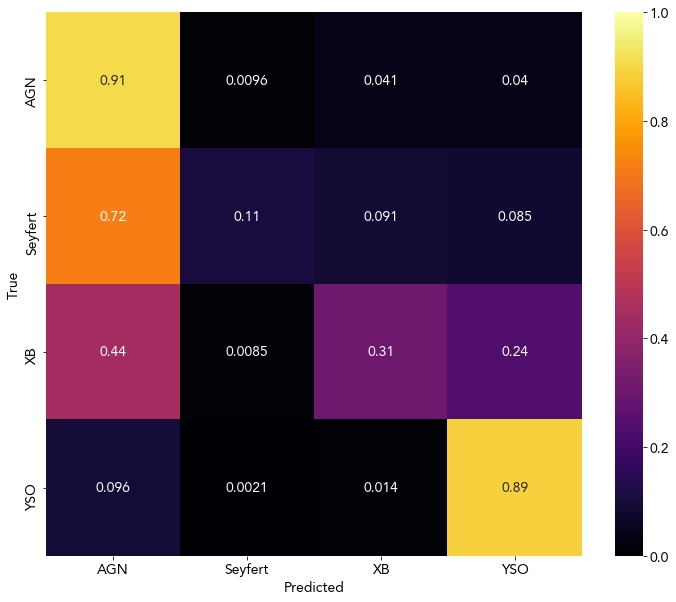

In [11]:
y_test_certain_grouped = y_test.replace(grouped_replace)
pred_class_certain_grouped = pd.DataFrame(clf.predict(X_test[features])).replace(grouped_replace)
new_ltypes = ['AGN', 'Seyfert', 'XB', 'YSO']
cf_matrix = confusion_matrix(y_test_certain_grouped, pred_class_certain_grouped, normalize='true', labels=new_ltypes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cf_matrix, annot=True, xticklabels = new_ltypes, yticklabels = new_ltypes, ax=ax, vmin=0, vmax=1, cmap="inferno")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.savefig('./figures/results_class_a_linearsvc_raw_unbalanced_grouped.pdf', bbox_inches='tight')

#### Our method

---

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data_clean, data_clean.main_type, test_size=0.2, stratify=data_clean.main_type, random_state=42)
y_test_sorted = X_test.sort_values(by=['name', 'obsid']).main_type
y_test_master = X_test.groupby(['name', 'main_type'], as_index=False).size()
X_test = X_test.assign(main_type='NaN')

In [9]:
X_train.shape

(8418, 96)

In [10]:
X_test.shape

(2105, 96)

In [11]:
pred_class_df = mahal_classifier_validation(X_train, X_test, features, ltypes, uks=uks)

***Cluster 0***
***Cluster 1***
***Cluster 2***
***Cluster 3***
***Cluster 4***
***Cluster 5***


In [ ]:
cf_matrix = confusion_matrix(y_test_sorted, pred_class_df.main_type, normalize='true', labels=ltypes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cf_matrix, annot=True, xticklabels = ltypes, yticklabels = ltypes, ax=ax, vmin=0, vmax=1, cmap="inferno")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.savefig('./figures/results_class_confusion_raw_out.pdf', bbox_inches='tight')

In [ ]:
y_test_certain_grouped = y_test_sorted.replace(grouped_replace)
pred_class_certain_grouped =  pred_class_df.main_type.replace(grouped_replace)
new_ltypes = ['AGN', 'Seyfert', 'XB', 'YSO']
cf_matrix = confusion_matrix(y_test_certain_grouped, pred_class_certain_grouped, normalize='true', labels=new_ltypes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cf_matrix, annot=True, xticklabels = new_ltypes, yticklabels = new_ltypes, ax=ax, vmin=0, vmax=1, cmap="inferno")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.savefig('./figures/results_class_confusion_raw_grouped_out.pdf', bbox_inches='tight')

In [ ]:
prob_mask = pred_class_df[ltypes].max(axis=1) > 0.7
pred_class_certain = pred_class_df[prob_mask.to_numpy()]
y_test_certain = y_test_sorted[prob_mask.to_numpy()]

In [ ]:
cf_matrix = confusion_matrix(y_test_certain, pred_class_certain.main_type, normalize='true', labels=ltypes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cf_matrix, annot=True, xticklabels = ltypes, yticklabels = ltypes, ax=ax, vmin=0, vmax=1, cmap="inferno")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.savefig('./figures/results_class_confusion_confident_out.pdf', bbox_inches='tight')

In [ ]:
y_test_certain_grouped = y_test_certain.replace(grouped_replace)
pred_class_certain_grouped = pred_class_certain.main_type.replace(grouped_replace)

cf_matrix = confusion_matrix(y_test_certain_grouped, pred_class_certain_grouped, normalize='true', labels=new_ltypes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cf_matrix, annot=True, xticklabels = new_ltypes, yticklabels = new_ltypes, ax=ax, vmin=0, vmax=1, cmap="inferno")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.savefig('./figures/results_class_confusion_confident_grouped_out.pdf', bbox_inches='tight')

In [12]:
def mean_std_round(x): return (str(round(np.std(x), 3)) + '±' + str(round(np.mean(x), 3)))
summ_table = pred_class_df.groupby('name')[ltypes].agg(mean_std_round)
summ_table['obs_count'] = pred_class_df.groupby(['name']).size()

summ_table_prov = pred_class_df.groupby('name')[ltypes].agg(['mean', 'std'])
class_mean_names = [list(tup) for tup in itertools.product(ltypes, ['mean'], repeat=1)]
names_comp = summ_table_prov[class_mean_names].idxmax(axis=1).to_list()
master_names = [name[0] for name in names_comp]
summ_table['master_class'] = master_names
summ_table.sort_values('obs_count', ascending=False, inplace=True)

In [13]:
n_obs = 0
y_true = y_test_master[y_test_master['size'] > n_obs].sort_values(by='name').main_type
y_pred = summ_table[summ_table['obs_count'] > n_obs].sort_values(by='name').master_class

'AvenirLTStd-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


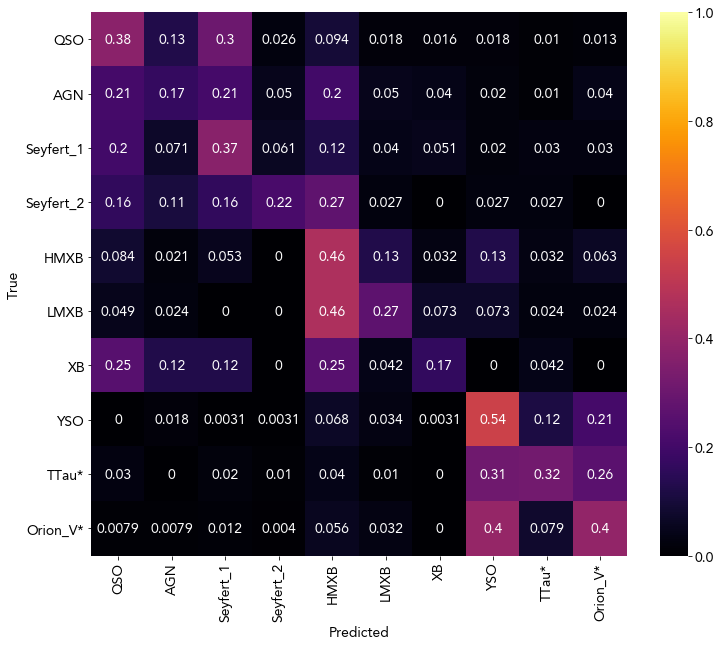

In [14]:
cf_matrix = confusion_matrix(y_true, y_pred, normalize='true', labels=ltypes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cf_matrix, annot=True, xticklabels = ltypes, yticklabels = ltypes, ax=ax, vmin=0, vmax=1, cmap="inferno")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.savefig('./figures/results_class_confusion_meanprob_0_out.pdf', bbox_inches='tight')

'AvenirLTStd-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


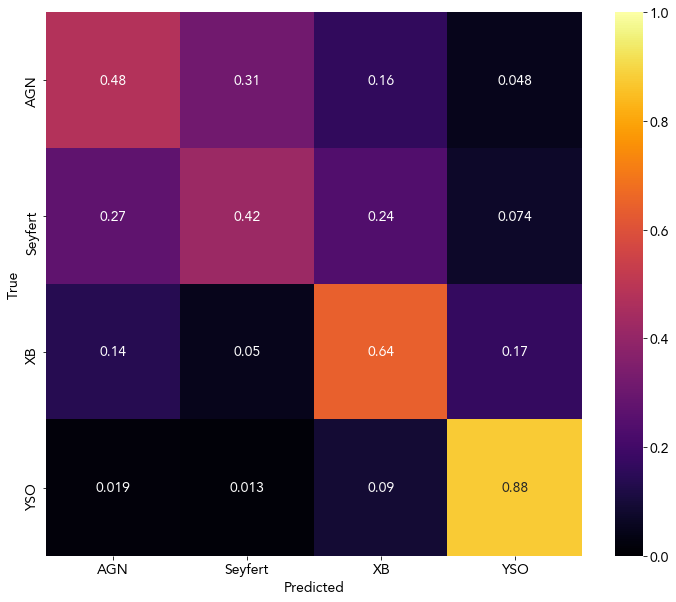

In [15]:
y_test_certain_grouped = y_true.replace(grouped_replace)
pred_class_certain_grouped =  y_pred.replace(grouped_replace)
new_ltypes = ['AGN', 'Seyfert', 'XB', 'YSO']
cf_matrix = confusion_matrix(y_test_certain_grouped, pred_class_certain_grouped, normalize='true', labels=new_ltypes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cf_matrix, annot=True, xticklabels = new_ltypes, yticklabels = new_ltypes, ax=ax, vmin=0, vmax=1, cmap="inferno")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.savefig('./figures/results_class_confusion_meanprob_0_grouped_out.pdf', bbox_inches='tight')

In [16]:
n_obs = 0
pred_class_df_grouped = pred_class_df.copy(deep=True)
def most_common(x): 
    most_common,name_most_common = Counter(x).most_common(1)[0]
    return(most_common) 

summ_table_common = pred_class_df_grouped.groupby(['name']).size().to_frame(name='obs_count')
summ_table_common = summ_table_common[summ_table_common.obs_count > n_obs]
summ_table_common['most_common'] = pred_class_df_grouped.groupby(['name'])['main_type'].agg(most_common)
summ_table_common.sort_values('obs_count', ascending=False, inplace=True)

In [17]:
y_pred = summ_table_common.sort_values(by='name').most_common

'AvenirLTStd-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


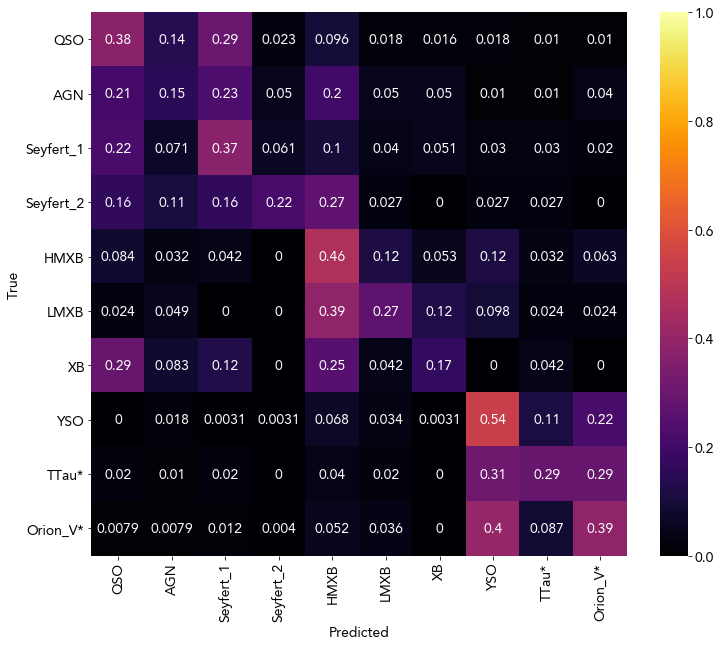

In [20]:
cf_matrix = confusion_matrix(y_test_master.main_type, y_pred, normalize='true', labels=ltypes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cf_matrix, annot=True, xticklabels = ltypes, yticklabels = ltypes, ax=ax, vmin=0, vmax=1, cmap="inferno")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.savefig('./figures/results_class_confusion_vote_0_out.pdf', bbox_inches='tight')

In [ ]:
y_test_certain_grouped = y_test_master[y_test_master['size'] > n_obs].main_type.replace(grouped_replace)
pred_class_certain_grouped =  y_pred.replace(grouped_replace)
new_ltypes = ['AGN', 'Seyfert', 'XB', 'YSO']
cf_matrix = confusion_matrix(y_test_certain_grouped, pred_class_certain_grouped, normalize='true', labels=new_ltypes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cf_matrix, annot=True, xticklabels = new_ltypes, yticklabels = new_ltypes, ax=ax, vmin=0, vmax=1, cmap="inferno")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.savefig('./figures/results_class_confusion_vote_0_grouped_out_final_agnqso.pdf', bbox_inches='tight')